In [1]:
import os
# os.environ['CUDA_VISIBLE_DEVICES'] = '5'
os.environ['CUDA_DEVICE_ORDER'] = 'PCI_BUS_ID'

In [2]:
!nvidia-smi

Fri Oct  6 15:07:42 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.125.06   Driver Version: 525.125.06   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  On   | 00000000:01:00.0 Off |                  N/A |
|  0%   33C    P8    28W / 280W |  14143MiB / 24576MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
# !pip install numba

In [4]:
import sys
sys.path.append('src/')

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import cv2

from zoo import ResNet3dCSN2P1D

import wandb
import pytorch_lightning as pl
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning.callbacks import LearningRateMonitor
from pytorch_lightning.callbacks import ModelCheckpoint

import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

from src.datasets.seg_dataset_test import DatasetSeg
from src.aug.seg_aug import SameResAugsAlbu
from losses.seg_loss import SegFastLossCalculator
from metrics.seg_metrics import multiclass_dice_coefficient
import glob

[2023-10-06 15:07:45,931] [INFO] [real_accelerator.py:133:get_accelerator] Setting ds_accelerator to cuda (auto detect)

===================================BUG REPORT===================================
Welcome to bitsandbytes. For bug reports, please run

python -m bitsandbytes

 and submit this information together with your error trace to: https://github.com/TimDettmers/bitsandbytes/issues
bin /usr/local/lib/python3.9/dist-packages/bitsandbytes/libbitsandbytes_cuda117.so
CUDA_SETUP: WARNING! libcudart.so not found in any environmental path. Searching in backup paths...
CUDA SETUP: CUDA runtime path found: /usr/local/cuda/lib64/libcudart.so.11.0
CUDA SETUP: Highest compute capability among GPUs detected: 8.6
CUDA SETUP: Detected CUDA version 117
CUDA SETUP: Loading binary /usr/local/lib/python3.9/dist-packages/bitsandbytes/libbitsandbytes_cuda117.so...


/usr/local/lib/python3.9/dist-packages/bitsandbytes/cuda_setup/main.py:149: UserWarning: WARNING: The following directories listed in your path were found to be non-existent: {PosixPath('/usr/local/nvidia/lib'), PosixPath('/usr/local/lib/python3.9/dist-packages/cv2/../../lib64'), PosixPath('/usr/local/nvidia/lib64')}
  warn(msg)
/usr/local/lib/python3.9/dist-packages/bitsandbytes/cuda_setup/main.py:149: UserWarning: /usr/local/lib/python3.9/dist-packages/cv2/../../lib64:/usr/local/lib/python3.9/dist-packages/nvidia/cudnn/lib:/usr/local/nvidia/lib:/usr/local/nvidia/lib64 did not contain ['libcudart.so', 'libcudart.so.11.0', 'libcudart.so.12.0'] as expected! Searching further paths...
  warn(msg)
/usr/local/lib/python3.9/dist-packages/bitsandbytes/cuda_setup/main.py:149: UserWarning: WARNING: The following directories listed in your path were found to be non-existent: {PosixPath('module'), PosixPath('//matplotlib_inline.backend_inline')}
  warn(msg)
/usr/local/lib/python3.9/dist-packages

In [5]:
# data = pd.read_csv("data/train_series_meta.csv")
# data['fold'] = [0]*len(data)
# data.to_csv("data/train_series_meta_folded.csv", index=False)

In [6]:
# ROOT = '/mnt/nvme13TB/RAW_DATASETS/rsna-2023/'
ROOT = 'data'

In [7]:

class Config:
    #dataset
    path_to_images   : str = os.path.join(ROOT, "train_images")
    path_to_meta_csv : str =  os.path.join(ROOT, "train_series_meta_folded.csv")
    path_to_masks    : str =  os.path.join(ROOT, "segmentations_png")
    fold       : int = 0
    height     : int = 256
    width      : int = 256
    slice_size : int = 112
    num_workes : int = 1
    
    #training
    num_classes      : int = 6
    batch_size       : int = 4
    wandb_project    : str = 'RSNA_segmentation'
    default_root_dir : str = 'seg'
    checkpoints_dir  : str = 'seg/checkpoints'
    lr               : float = 1e-3
    max_epochs       : int = 30

In [8]:
augmentation_instance = SameResAugsAlbu()
augmentations = augmentation_instance.get_train_augmentations()

train_dataset = DatasetSeg(mode = "train",
                             #fold = Config.fold,
                             path_to_images = Config.path_to_images,
                             path_to_meta_csv = Config.path_to_meta_csv,
                             #path_to_masks = Config.path_to_masks,
                             #transforms = augmentations,
                             shape = (Config.height, Config.width),
                             slice_size = Config.slice_size)

val_dataset = DatasetSeg(mode = "eval",
                             #fold = Config.fold,
                             path_to_images = Config.path_to_images,
                             path_to_meta_csv = Config.path_to_meta_csv,
                             #path_to_masks = Config.path_to_masks,
                             #transforms = augmentations,
                             shape = (Config.height, Config.width),
                             slice_size = Config.slice_size)

In [9]:
train_dataset.meta.patient_id.unique().shape

(3147,)

In [10]:
batch_size = 1
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False, num_workers=Config.num_workes)

In [11]:
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False, num_workers=Config.num_workes)

In [12]:
%%time
for batch_idx, batch in enumerate(train_loader):
    batch = next(iter(train_loader))
    print(f"Batch {batch_idx}:")
    print(f"Keys {batch.keys()}")
    print(f"Scan ids {batch['scan_id']}")
    print(f"Images shape {batch['image'].shape}")
    break

augmentation, allert!
augmentation, allert!
augmentation, allert!
augmentation, allert!
augmentation, allert!
Batch 0:
Keys dict_keys(['image', 'patient_id', 'scan_id'])
Scan ids tensor([48437])
Images shape torch.Size([1, 1, 112, 256, 256])
CPU times: user 2.3 ms, sys: 29.6 ms, total: 31.9 ms
Wall time: 1.8 s


In [13]:
class LitSegmentator3d(pl.LightningModule):

    def __init__(self, Config, encoder="r50ir", **kwargs):
        super().__init__()
        self.args = Config
        self.learning_rate = Config.lr
        
        self.save_hyperparameters()
        
        self.model = ResNet3dCSN2P1D(encoder=encoder, num_classes=Config.num_classes)
        
        self.loss_fn = SegFastLossCalculator()
    
    def forward(self, batch):
        return self.model(batch['image'])['mask']
        
    def training_step(self, batch, batch_idx):
        cubes = batch['image']
        pred = self.model(cubes)
        
        '''
        pred_mask shape = (b_s, C, z, x, y) С - колличество классов
        true_masks shape = (b_s, z, x, y) значкния классов в кубе от 0 до С - 1; бэкграунд = 255
        '''
        loss = self.loss_fn.calculate_loss(pred, batch)
        
        self.log("train_loss", loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)        
        return loss
    
    def predict_step(self, batch, batch_idx):
        cubes = batch['image']
        pred = self.model(cubes)
        
        '''
        pred_mask shape = (b_s, C, z, x, y) С - колличество классов
        true_masks shape = (b_s, z, x, y) значкния классов в кубе от 0 до С - 1; бэкграунд = 255
        '''
        
        return pred
    
    def get_metrics(self, batch, outputs):
        dice_coeff = multiclass_dice_coefficient(outputs['mask'], batch['mask'], self.args.num_classes)
        return dice_coeff
        
    def validation_step(self, batch, batch_idx):
        cubes = batch['image']
        pred = self.model(cubes)
        
        loss = self.loss_fn.calculate_loss(pred, batch)
        
        dice_coeff = self.get_metrics(outputs=pred, batch=batch)
        
        self.log("val_loss", loss)
        self.log("val_dice", dice_coeff)
    
    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.model.parameters(), lr=self.learning_rate)
        lr_scheduler = {
                        'scheduler': torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min',
                                                                                factor=0.5,
                                                                                patience=3,
                                                                                threshold=0.07,),
                        'interval': 'epoch',
                        'frequency': 1,
                        'monitor': "train_loss",
                        'name': 'lr/reduce_on_plateau'
                        }
        return [optimizer], [lr_scheduler]

In [14]:
encoder_name = "r50ir"

In [15]:
# wandb.login()
# wandb_logger = WandbLogger(project = Config.wandb_project, name = encoder_name)

In [16]:
model = LitSegmentator3d(Config = Config, encoder = encoder_name)

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/loss.py:222: UserWarning: NLLLoss2d has been deprecated. Please use NLLLoss instead as a drop-in replacement and see https://pytorch.org/docs/master/nn.html#torch.nn.NLLLoss for more details.
  warnings.warn("NLLLoss2d has been deprecated. "
/usr/local/lib/python3.9/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


In [17]:
# lr_monitor = LearningRateMonitor(logging_interval = 'epoch')

# checkpoint_callback = ModelCheckpoint(dirpath = Config.checkpoints_dir,
#                                       monitor = 'val_loss',
#                                       save_top_k = 3,
#                                       filename = './{epoch}-{val_loss:.3f}.pt',
#                                       mode = 'min')

# trainer = pl.Trainer(
#                     # logger = wandb_logger,
#                      default_root_dir = Config.default_root_dir,
#                      accelerator = 'cpu',
# #                      precision = '16',
#                      callbacks = [checkpoint_callback, lr_monitor],
#                      max_epochs = Config.max_epochs,
#                      check_val_every_n_epoch = 3,
#                      )

# trainer.fit(model, train_dataloaders = train_loader, val_dataloaders = val_loader)

In [18]:
#preds = trainer.predict(model, train_loader)

In [19]:
model.load_state_dict(torch.load('weights/seg/6cls_last.pt', map_location='cpu'))
model.model.to('cpu')
model.eval()
print()

In [20]:
# val_preds = []
# for batch_idx, batch in enumerate(val_loader):
#     with torch.inference_mode():
#         pred = model.model(batch['image'].to('cuda'))['mask'].argmax(dim=1)
#         val_preds.extend(pred.detach().cpu().numpy())

In [21]:
# train_preds = []
# for batch_idx, batch in enumerate(train_loader):
#     with torch.inference_mode():
#         pred = model.model(batch['image'].to('cuda'))['mask'].argmax(dim=1)
#         train_preds.extend(pred.detach().cpu().numpy())
#     break

In [22]:
for batch in val_loader:
    break

In [23]:
print(batch['image'].shape)
print(batch['patient_id'])
print(batch['scan_id'])

torch.Size([1, 1, 112, 256, 256])
tensor([10721])
tensor([48437])


In [24]:
raw_pred = model.model(batch['image'].to('cpu'))['mask']

In [25]:
raw_pred.shape

torch.Size([1, 6, 112, 256, 256])

In [26]:
im = batch['image'][0][0]

In [27]:
pred = raw_pred.argmax(1)

In [28]:
np.unique(pred)

array([0, 1, 2, 3, 4, 5])

In [29]:
#gt = batch['mask'][0].detach().cpu().numpy().astype(np.uint8)
pr = pred[0].detach().cpu().numpy().astype(np.uint8)

In [30]:
pr.shape

(112, 256, 256)

In [31]:
def find_single_bounding_box_per_class(prediction, padding):
    bounding_boxes = {}
    classes = np.unique(prediction)
    for c in classes:
        if c == 0:  # фон
            continue
        coords = np.argwhere(prediction == c)
        #print(coords.shape)
        z_min, y_min, x_min = coords.min(axis=0)
        z_max, y_max, x_max = coords.max(axis=0)

        bounding_boxes[c] = ((x_min / 256, x_max / 256), (y_min / 256, y_max / 256), (z_min / 112, z_max / 112))
    return bounding_boxes

In [32]:
find_single_bounding_box_per_class(pr, 0)

{1: ((0.15234375, 0.61328125),
  (0.27734375, 0.6484375),
  (0.05357142857142857, 0.375)),
 2: ((0.57421875, 0.77734375),
  (0.51171875, 0.63671875),
  (0.08928571428571429, 0.1875)),
 3: ((0.546875, 0.71484375),
  (0.51171875, 0.640625),
  (0.16964285714285715, 0.35714285714285715)),
 4: ((0.234375, 0.41015625),
  (0.46875, 0.625),
  (0.23214285714285715, 0.41964285714285715)),
 5: ((0.23046875, 0.77734375),
  (0.25390625, 0.6640625),
  (0.044642857142857144, 0.8214285714285714))}

In [38]:
print(len(os.listdir("data/train_images/10721/63796")))
print(len(os.listdir("data/train_images/10721/48437")))

59
210


In [33]:
im.shape

torch.Size([112, 256, 256])

1


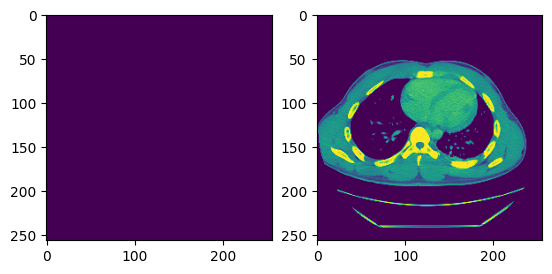

6


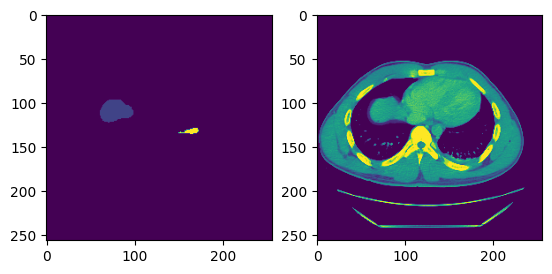

11


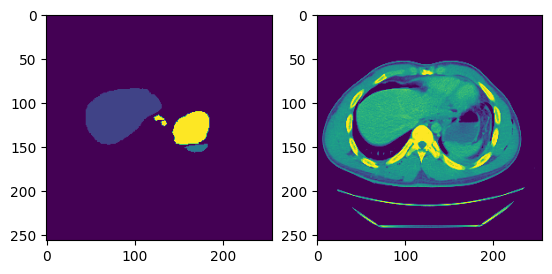

16


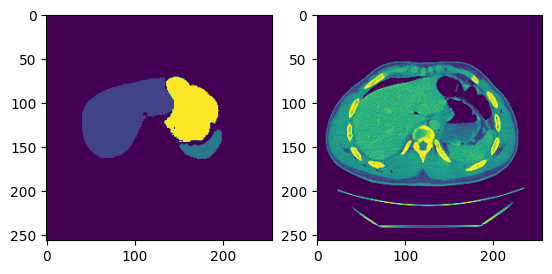

21


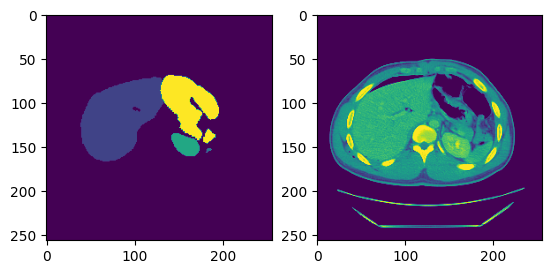

26


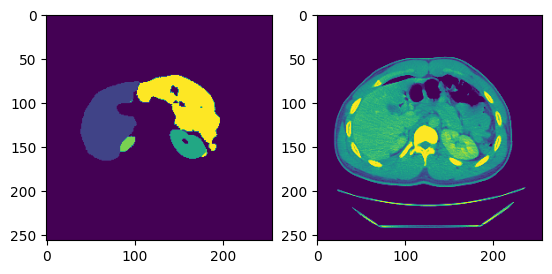

31


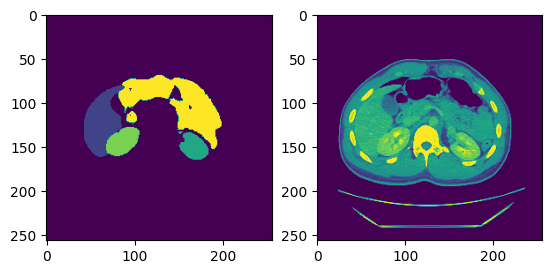

36


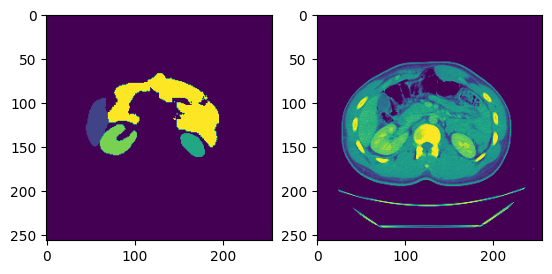

41


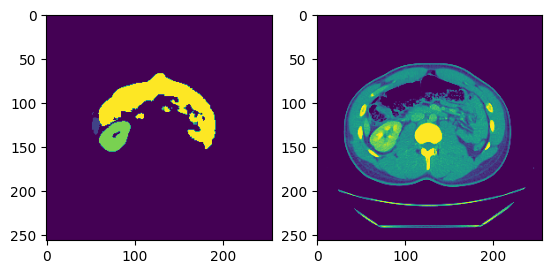

46


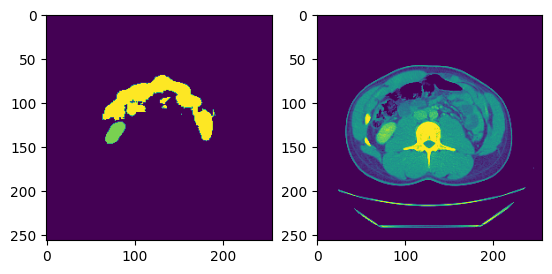

51


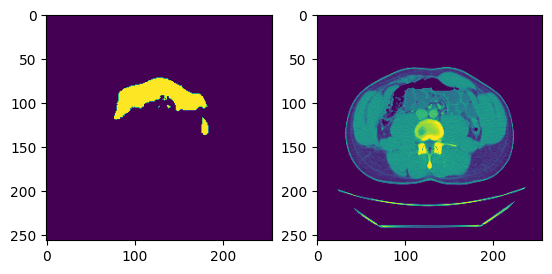

56


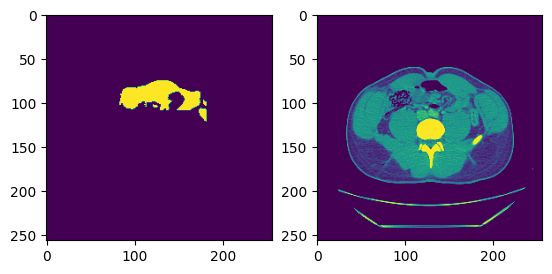

61


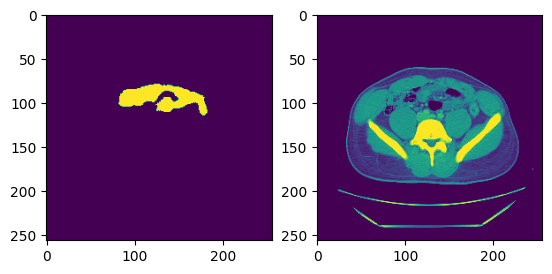

66


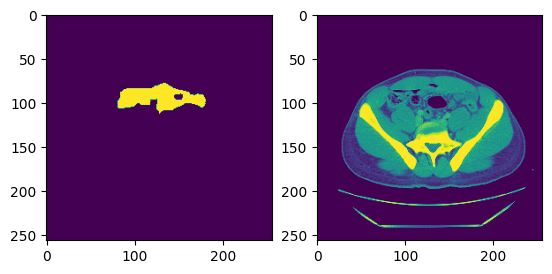

71


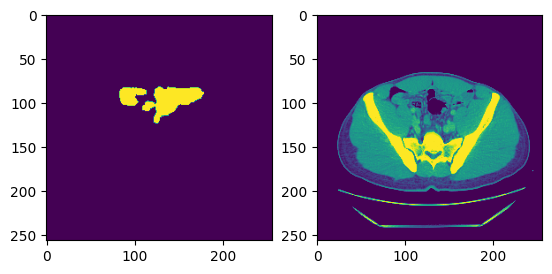

76


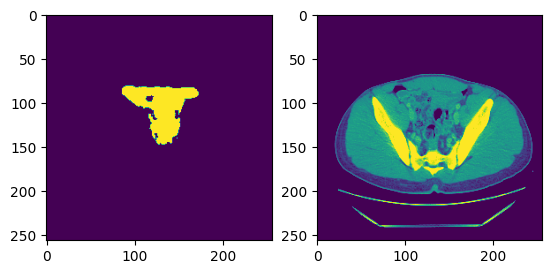

81


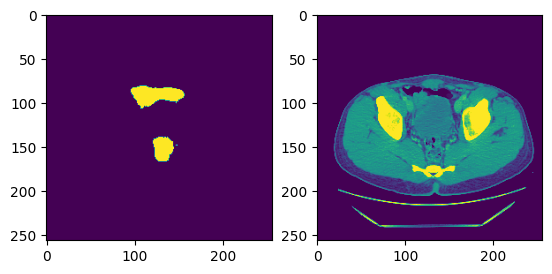

86


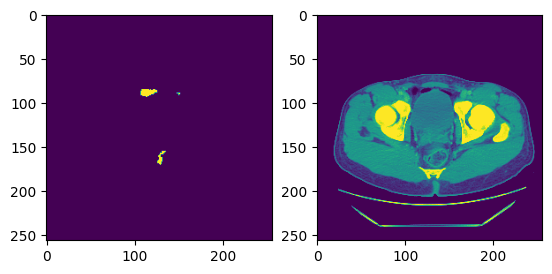

91


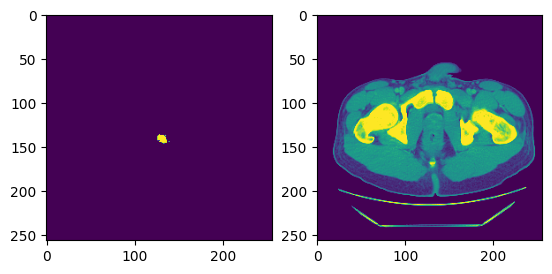

96


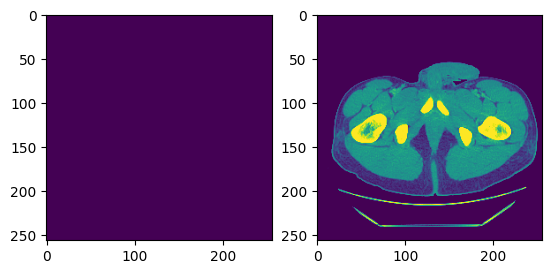

101


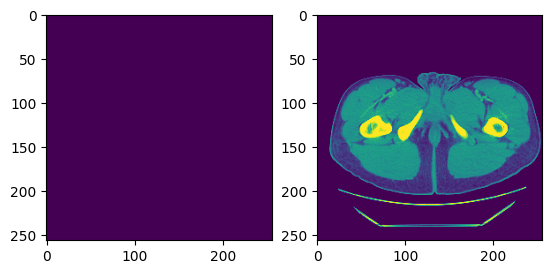

106


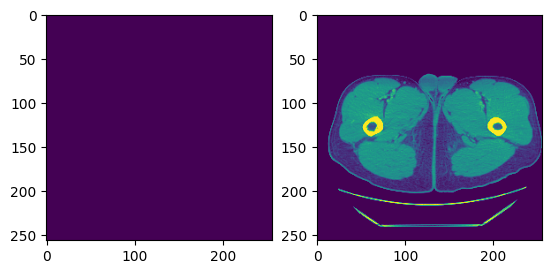

In [35]:
for i in range(1, 110, 5):
    print(i)
    fig, axes = plt.subplots(ncols=2)
    axes[0].imshow(pr[i,:,:])
    axes[1].imshow(im[i,:,:])
    plt.show()